## Loading the data


In [1]:
import pandas as pd
import numpy as np
import nltk
import spacy

In [2]:
train_df = pd.read_csv('train.csv')

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
len(train_df)

7613

In [7]:
df = train_df[['id', 'text', 'target']]

In [8]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

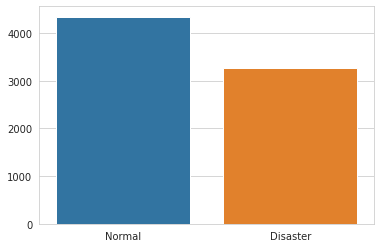

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

sns.barplot(x=['Normal','Disaster'], y= df.target.value_counts().values)
plt.show()

## Cleaning data

In [11]:
import warnings
warnings.filterwarnings(action='ignore')

In [12]:
# dropping all dublicate data
l = len(df)
df.drop_duplicates(subset='text', inplace=True)
print("Total Duplicates ", l - len(df))

Total Duplicates  0


In [13]:
# Dropping nan values

null_rows = df['text'][df['text'].isna()]
null_rows

Series([], Name: text, dtype: object)

## Text processing


*   Removing mentions with @
*   removing symbols

*   lowercase words





In [14]:
import re

In [15]:
def clean_text(text):
    te = str(text).encode('ascii','ignore').decode('UTF-8')
    te = re.sub(r'@[\w]+', '', te)
    te = re.sub(r'https?://t.co/[\w]+', '', te)
    te = re.sub(r'#', '', te)
    te = re.sub(r"RT @[\w]+:",'',te)
    te = re.sub(r"RT @[\w]+:",'',te)
    te = re.sub(r" RT ",'',te)
    te = re.sub(r"https://[\w]+.[\w]+/[\w]+",'',te)
    te = re.sub(r"[][]",'',te)
    te = re.sub(r"&amp","and", te)
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", te)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

## Vectorization from text to neumerical data 


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_text,
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(df.text)

## Creating model, training and evaluation

In [18]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, make_scorer, f1_score, accuracy_score
from sklearn.model_selection import KFold, cross_val_score

In [19]:
est = []
est.append(('LogisticRegression', Pipeline([('LR', LogisticRegression())])))
est.append(('BernoulliNB', Pipeline([('BNB', BernoulliNB())])))
est.append(('MultinomialNB', Pipeline([('MNB', MultinomialNB())])))
est.append(('LinearSVC', Pipeline([('LNB', LinearSVC())])))

In [20]:
# Training
model_scores = {}

p_scorer = make_scorer(precision_score)
r_scorer = make_scorer(recall_score)
f1_scorer = make_scorer(f1_score)
a_scorer = make_scorer(accuracy_score)

for i in est:
    kfold = KFold(n_splits=7, shuffle=True, random_state=4)
    p_scores = cross_val_score(i[1], training_features, df.target, cv=kfold, scoring=p_scorer)
    r_scores = cross_val_score(i[1], training_features, df.target, cv=kfold, scoring=r_scorer)
    f1_scores = cross_val_score(i[1], training_features, df.target, cv=kfold, scoring=f1_scorer)
    a_scores = cross_val_score(i[1], training_features, df.target, cv=kfold, scoring=a_scorer)
    
    model_scores.update({ i[0]:{'accuracy': a_scores.mean(), 'f1_score':f1_scores.mean(), 'precision': p_scores.mean(), 'recall':r_scores.mean()} })

In [21]:
for i in model_scores:
    print('\n', i)
    print('\n', model_scores[i])


 LogisticRegression

 {'accuracy': 0.7867510188154864, 'f1_score': 0.6913762678935791, 'precision': 0.9020825163884113, 'recall': 0.5611933646051182}

 BernoulliNB

 {'accuracy': 0.7823546085100707, 'f1_score': 0.6822734634350262, 'precision': 0.902549048840556, 'recall': 0.5491051718786335}

 MultinomialNB

 {'accuracy': 0.7990159994345997, 'f1_score': 0.7262441928404598, 'precision': 0.8653905380791863, 'recall': 0.6262223895962482}

 LinearSVC

 {'accuracy': 0.8016792537910687, 'f1_score': 0.7393408699826887, 'precision': 0.8411023438498465, 'recall': 0.6600685722663211}


In [22]:
top_models_score = sorted(model_scores.items(), key=lambda k:k[1]['f1_score'], reverse=True)
top_models_score[0]

('LinearSVC',
 {'accuracy': 0.8016792537910687,
  'f1_score': 0.7393408699826887,
  'precision': 0.8411023438498465,
  'recall': 0.6600685722663211})

In [25]:
top_model = dict(est)[top_models_score[0][0]]
top_model.fit(training_features, df.target)

Pipeline(memory=None,
         steps=[('LNB',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)

### So the top model that we could see based on f1 score is Linear SVC, We will work with this model

## Prediction from test dataset

In [23]:
test_df = pd.read_csv('test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [26]:
# Vectorization of text of test dataset and using the best performing f1 score model
test_features = vectorizer.transform(test_df.text)
predictions = top_model.predict(test_features)

In [27]:
#the predicted score into a new dataframe
res = pd.DataFrame(columns=['id', 'text', 'prediction'])
res['id'] = test_df['id']
res['text'] = test_df['text']
res['prediction'] = predictions


In [29]:
res.sample(10)

,id,text,prediction
932,3076,HEALTH FACT: Women account for 39% of smoking ...,1
623,2030,Warfighting Robots Could Reduce Civilian Casua...,1
1801,6081,Good morning. Slept about 6 hours. The heat wa...,1
1690,5709,Bengal floods: CM Mamata Banerjee blames DVC B...,1
3174,10530,Rocky Fire #cali #SCFD #wildfire #LakeCounty h...,1
182,593,#LGBTQ News ?? Owner of Chicago-Area Gay Bar A...,0
582,1894,Peddle to the floorboard.. End up in a four do...,0
469,1528,Womens Flower Printed Shoulder Handbags Cross ...,0
3118,10328,@sindy642498 \nI'm really glad to hear thatÛ_...,0
523,1713,Australia's Ashes disaster - how the collapse ...,1
